In [1]:
import torch
from torch import nn
import torch.distributions as dist
torch.manual_seed(0)

import matplotlib.pyplot as plt
import numpy as np

In [2]:
POS = 10**(-3)  # try reduce this -> error non-positive definite
EPS = 1e-6
DIAG = 0.1

# One dimensional - direct

### Training

In [3]:
class ApproxTruncation(nn.Module):
    def __init__(self, xdim, num_component_input=2, num_component_output=2, nsamples=500):
        super(ApproxTruncation, self).__init__()
        self.num_component_input = num_component_input
        self.num_component_output = num_component_output
        
        self.xdim = xdim
        self.out_dim = int(self.num_component_output*(1+self.xdim+self.xdim*(self.xdim+1)/2))   # changed to produce triangular matrices

        self.network = nn.Sequential(
            nn.Linear(self.xdim, 24),
            nn.LeakyReLU(0.2),
            nn.Linear(24, 48),
            nn.LeakyReLU(0.2),
            nn.Linear(48, 48),
            nn.LeakyReLU(0.2),
            nn.Linear(48,24),
            nn.LeakyReLU(0.2),
            nn.Linear(24, self.out_dim),
        )

        self.lay = nn.Linear(nsamples, 1)

    def forward(self, samples):

        output = self.network(samples)

        fl_output = self.lay(output.t())

        fl_output = fl_output.reshape((self.num_component_output,-1))

        weights = torch.sigmoid(fl_output[:, 0])
        weights = weights / weights.sum()
        mus = torch.exp(fl_output[:, 1:self.xdim+1])                                                        # put exp instead of relu
        
        if self.xdim == 1:
            covs = torch.exp(fl_output[:, self.xdim+1:].reshape((self.num_component_output, self.xdim, self.xdim)))
        else:
            # uses triangular matrices
            sigmas = torch.zeros((self.num_component_output, self.xdim, self.xdim))
            covs = torch.zeros((self.num_component_output, self.xdim, self.xdim))      
            for i in range(self.num_component_output):
                sigmas[i][np.triu_indices(self.xdim),1] = fl_output[i, self.xdim+1:-self.xdim]
                sigmas[i][np.diag_indices(self.xdim)] = torch.relu(fl_output[i, -self.xdim:]) + DIAG
                covs[i] = torch.mm(sigmas[i],sigmas[i].t()) #+ POS*torch.eye(self.xdim)

        return weights, mus, covs

In [4]:
EPS = 10**(-6)
def loss_function(samples, weights, means, covariances):

    # samples: [n_samples, xdim]
    n_samples, xdim = samples.shape

    components = weights.shape[0]

    #Generate the gaussian mixture
    distributions = [dist.MultivariateNormal(means[i], covariances[i]) for i in range(components)]
        
    log_probs = torch.zeros(samples.shape[0], components)
    
    for i in range(components):
        log_probs[:, i] = distributions[i].log_prob(samples) + torch.log(weights[i]+EPS)   

    # Log-sum-exp for numerical stability
    max_log_probs, _ = torch.max(log_probs, dim=1, keepdim=True)
    log_probs = torch.log(torch.sum(torch.exp(log_probs - max_log_probs), dim=1)) + max_log_probs.squeeze()

    #loss = torch.tensor(0.)
    #for i in range(components):
    #    loss += 0.5*torch.pow(torch.sqrt(1/covariances[i])*(samples - means[i]), 2).mean()
    #    loss -= torch.sqrt(1/covariances[i]).reshape([])
    #return loss
    
    return -log_probs.mean() #+ torch.sum(torch.pow(torch.mean(samples, dim=0) - means, 2)) + torch.sum(torch.pow(covariances, 2))

In [5]:
def generate_random_covariance(dim, lb, ub):
    #A = torch.empty(dim, dim).uniform_(lb, ub)
    
    # generate triangular
    A = torch.zeros((dim, dim))
    A[np.triu_indices(dim,1)] = torch.empty(int(dim*(dim-1)/2)).uniform_(lb, ub)
    A[np.diag_indices(dim)] = torch.empty(dim).uniform_(DIAG, ub) #strictly positive diagonal
    
    cov_matrix = torch.rand(1)*torch.mm(A, A.t())  # Make it symmetric and semi-definite, added multiplicative factor to make the range vary
    #cov_matrix += POS*torch.eye(dim)  # Make it positive definite

    return cov_matrix

def _truncate_samples(samples, dist):
    # Iteratively resample until all values are positive
    while torch.any(samples < 0):
        negative_indices = torch.any(samples < 0,dim=1)
        new_samples = dist.sample((negative_indices.sum(),))
        samples[negative_indices] = new_samples#[negative_indices]
    return samples

#def _truncate_samples(samples, dist):
#    # Iteratively resample until all values are positive
#    while torch.any(samples[:, 0] < 0):
#        negative_indices = torch.where(samples[:,0] < 0)[0]
#        new_samples = dist.sample((len(negative_indices),))
#        samples[negative_indices] = new_samples
#    return samples

def gm_sampling(pis, mus, sigmas, num_samples):
    
    gm_distributions = [dist.MultivariateNormal(mus[i], sigmas[i]) for i in range(len(pis))]
    
    component_choices = torch.multinomial(pis, num_samples, replacement=True)
    samples = torch.zeros(num_samples, mus.shape[1])

    for i in range(len(pis)):
        mask = (component_choices == i)
        num_samples_i = mask.sum()
        if num_samples_i > 0:
            tsamples = gm_distributions[i].sample((num_samples_i,))
            samples[mask] = _truncate_samples(tsamples, gm_distributions[i])
            #samples[mask] = gm_distributions[i].sample((num_samples_i,))
    return samples

In [6]:
# number of samples generated per gaussian mixture during training
nsamples = 100   # increased number of samples   
# number of gaussian mixtures seen during training
niter = 100000

ncomp = 1
xdim = 1

lb_mu = 0
ub_mu = 100
lb_sigma = -10
ub_sigma = 10


In [7]:
model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp, nsamples=nsamples)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

model.train()

losses = []
for t in range(niter):

    optimizer.zero_grad()
    weights = torch.rand(ncomp)
    weights = weights / weights.sum()  # Normalize to sum to 1
    means = torch.empty(ncomp, xdim).uniform_(lb_mu, ub_mu)
    covariances = torch.empty(ncomp, xdim, xdim)
    for j in range(ncomp):
        covariances[j] = generate_random_covariance(xdim, lb_sigma, ub_sigma)
    
    samples = gm_sampling(weights, means, covariances, nsamples)

    pi_new, mu_new, sigma_new = model(samples)

    #components = pi_new.shape[0]
    #distributions = [dist.MultivariateNormal(mu_new[i], sigma_new[i]) for i in range(components)]

    loss = loss_function(samples, pi_new, mu_new, sigma_new)

    # Backpropagation
    loss.backward()
    optimizer.step()

    if t % 1000 == 0:
      tloss = loss.item() #batch * batch_size + len(X)
      losses.append(tloss)
      print(f"loss: {tloss:>7f} {np.round(t/niter*100,3)}%")

    if t % 10000 == 0:
        print('generated', means, covariances)
        print('predicted', mu_new, sigma_new)

print("Done!")

loss: 3582.203125 0.0%
generated tensor([[87.1233]]) tensor([[[2.1966]]])
predicted tensor([[0.7024]], grad_fn=<ExpBackward0>) tensor([[[1.0378]]], grad_fn=<ExpBackward0>)
loss: 92.573517 1.0%
loss: 36.915836 2.0%
loss: 10.170521 3.0%
loss: 6.696948 4.0%
loss: 5.725863 5.0%
loss: 5.836722 6.0%
loss: 8.479815 7.0%
loss: 7.635413 8.0%
loss: 4.091225 9.0%
loss: 8.420867 10.0%
generated tensor([[95.7505]]) tensor([[[69.9352]]])
predicted tensor([[1101.7103]], grad_fn=<ExpBackward0>) tensor([[[1962814.7500]]], grad_fn=<ExpBackward0>)
loss: 4.787001 11.0%
loss: 5.885650 12.0%
loss: 6.968954 13.0%
loss: 7.813807 14.0%
loss: 4.832395 15.0%
loss: 8.077644 16.0%
loss: 5.571854 17.0%
loss: 5.526316 18.0%
loss: 4.559655 19.0%
loss: 3.611260 20.0%
generated tensor([[12.5172]]) tensor([[[16.5493]]])
predicted tensor([[9.1268]], grad_fn=<ExpBackward0>) tensor([[[10.8475]]], grad_fn=<ExpBackward0>)
loss: 2.516474 21.0%
loss: 3.690588 22.0%
loss: 3.858294 23.0%
loss: 3.554418 24.0%
loss: 4.383433 25.0%

In [42]:
torch.save(model, 'params/truncNNdim1-direct-1to1.pth')

In [43]:
fig = plt.figure()
plt.plot(np.arange(len(losses)), losses)
plt.title('loss')
plt.xlabel('iterations')
plt.ylim(0,100)
plt.show()

NameError: name 'losses' is not defined

<Figure size 640x480 with 0 Axes>

### Test

In [47]:
ncomp = 1
xdim = 1
nsamples = 100

model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp, nsamples=nsamples)
model = torch.load('params/truncNNdim1-direct-1to1.pth')

C:\Users\birik\AppData\Local\Temp\ipykernel_27912\3689444106.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('params/truncNNdim1-direct-1to1.pth')


In [48]:
test_weights = torch.rand(ncomp)
test_weights = test_weights / test_weights.sum()  # Normalize to sum to 1
test_means = torch.empty(ncomp, xdim).uniform_(0, 10)
test_covariances = torch.empty(ncomp, xdim, xdim)

for j in range(ncomp):
  test_covariances[j] = generate_random_covariance(xdim, -5, 5)

test_samples = gm_sampling(test_weights, test_means, test_covariances, nsamples)

pi_pred, mu_pred, sigma_pred = model(test_samples)

print('Test params:', test_weights, test_means, test_covariances)
print('Pred params:', pi_pred, mu_pred, sigma_pred)

Test params: tensor([1.]) tensor([[7.4222]]) tensor([[[1.1471]]])
Pred params: tensor([1.], grad_fn=<DivBackward0>) tensor([[9.6497]], grad_fn=<ExpBackward0>) tensor([[[16.0369]]], grad_fn=<ExpBackward0>)


In [49]:
import libSOGA

soga_dist = libSOGA.Dist(['x'], libSOGA.GaussianMix(np.array([1.]), [np.array(test_means[0])], [np.array(test_covariances[0])]))
_, new_soga_dist = libSOGA.truncate(soga_dist, 'x>0', {})

soga_w = new_soga_dist.gm.pi[0]
soga_mean = new_soga_dist.gm.mu[0]
soga_cov = new_soga_dist.gm.sigma[0]

soga_w, soga_mean, soga_cov

(1.0, array([7.42216206]), array([[1.1470933]]))

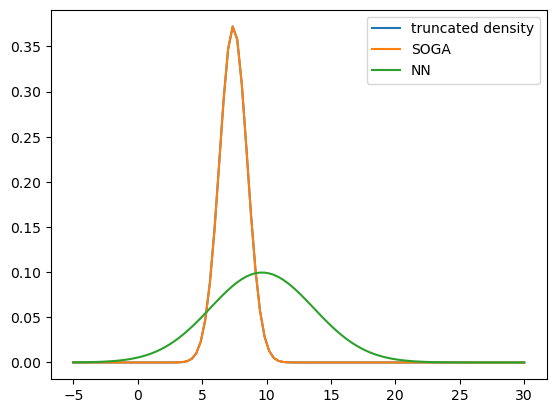

In [50]:
from scipy.stats import truncnorm
from scipy.stats import norm

# Plotting
x = np.linspace(-5,30,100)

loc = test_means[0]
scale = np.sqrt(test_covariances[0])
a = -loc/scale
b = np.inf

y_trunc = truncnorm.pdf(x, a, b, loc, scale).reshape(x.shape)
y_soga = norm.pdf(x, soga_mean, np.sqrt(soga_cov)).reshape(x.shape)
y_nn = norm.pdf(x, mu_pred.detach().numpy(), np.sqrt(sigma_pred.detach().numpy())).reshape(x.shape)

#plt.hist(test_samples.t(), bins=10, range=(40,50), density=True, label='samples')

plt.plot(x, y_trunc, label='truncated density')
plt.plot(x, y_soga, label='SOGA')
plt.plot(x, y_nn, label='NN')

plt.legend()

# One dimensional - inverse

Dobbiamo usare la direct KL invece della reverse (la likelihood e' equivalente alla reverse).

Sia $q$ la distribuzione usata per la stima e $p$ la troncata che vogliamo approssimare.

$$ KL(q || p) = \mathbb{E}_q\big[\log\big(\frac{q}{p}\big)\big] = H(q) - \mathbb{E}_q[\log(p)] = H(q) - \int_{\mathbb{R}^2} q(s) \log(p(s)) dx $$

In [3]:
class ApproxTruncation(nn.Module):
    def __init__(self, xdim, num_component_input=1, num_component_output=1):
        super(ApproxTruncation, self).__init__()
        self.num_component_input = num_component_input
        self.num_component_output = num_component_output
        
        self.xdim = xdim
        self.inp_dim = int(self.num_component_input*(1+self.xdim+self.xdim**2)) 
        self.out_dim = int(self.num_component_output*(1+self.xdim+self.xdim*(self.xdim+1)/2))   # changed to produce triangular matrices

        self.network = nn.Sequential(
            nn.Linear(self.inp_dim, 24),
            nn.LeakyReLU(0.2),
            nn.Linear(24, 48),
            nn.LeakyReLU(0.2),
            nn.Linear(48, 48),
            nn.LeakyReLU(0.2),
            nn.Linear(48,24),
            nn.LeakyReLU(0.2),
            nn.Linear(24, self.out_dim),
        )

    def forward(self, params):

        output = self.network(params)
        
        weights = torch.sigmoid(output[:self.num_component_output])
        weights = weights / weights.sum()
        mus = torch.exp(output[self.num_component_output:self.num_component_output*(self.xdim+1)]).reshape((self.num_component_output, self.xdim))                                                       

        if self.xdim == 1:
            covs = torch.exp(output[self.num_component_output*(self.xdim+1):]).reshape((self.num_component_output, 1))
        else:
            # uses triangular matrices
            sigmas = torch.zeros((self.num_component_output, self.xdim, self.xdim))
            covs = torch.zeros((self.num_component_output, self.xdim, self.xdim))      
            for i in range(self.num_component_output):
                sigmas[i][np.triu_indices(self.xdim),1] = fl_output[i, self.xdim+1:-self.xdim]
                sigmas[i][np.diag_indices(self.xdim)] = torch.relu(fl_output[i, -self.xdim:]) + DIAG
                covs[i] = torch.mm(sigmas[i],sigmas[i].t()) #+ POS*torch.eye(self.xdim)

        return weights, mus, covs

In [ ]:
GRID = torch.linspace(EPS, 10, 100)
delta = GRID[1] - GRID[0]
nsamples = 500

from botorch.utils.probability.truncated_multivariate_normal import TruncatedMultivariateNormal as TruncNorm

def loss_function(params, weights, means, covariances):

    ncomp = weights.shape[0]
    xdim = means[0].shape[0]

    w_trunc = params[:ncomp]
    mu_trunc = params[ncomp:ncomp*(xdim+1)].reshape(ncomp,xdim)
    cov_trunc = params[ncomp*(xdim+1):].reshape(ncomp,xdim,xdim)

    if xdim == 1 & ncomp == 1:
        norm = dist.Normal(means[0], covariances[0])          # Normal distribution (the one we are estimating)
        tnorm = dist.Normal(mu_trunc, torch.sqrt(cov_trunc))  # Truncated normal (the one we want to approximate)
        norm_factor = 1 - tnorm.cdf(torch.tensor(0.))         # Normalization factor for truncated normal
        loss = norm.entropy() - delta*torch.sum(torch.exp(norm.log_prob(GRID))*(tnorm.log_prob(GRID)-torch.log(norm_factor)))

        #norm = dist.Normal(means[0], covariances[0])          # Normal distribution (the one we are estimating)
        #samples = norm.sample((nsamples,1))                   # generates samples from normal
        #positive_indices = torch.any(samples > 0, dim=1)      # negative samples have likelihood 0
        #tnorm = dist.Normal(mu_trunc, torch.sqrt(cov_trunc))  # Truncated normal (the one we want to approximate)
        #norm_factor = 1 - tnorm.cdf(torch.tensor(0.))         # Normalization factor for truncated normal 
        #loss = norm.entropy() - torch.mean(tnorm.log_prob(samples[positive_indices])-torch.log(norm_factor))
        return loss
    

### Training

In [12]:
# number of gaussian mixtures seen during training
niter = 50000

ncomp = 1
xdim = 1

lb_mu = 0
ub_mu = 10
lb_sigma = -5
ub_sigma = 5

# changed the bounds
#bounds_mu = [lb_mu*torch.ones(xdim),ub_mu*torch.ones(xdim)]
#bounds_sigma = [lb_sigma**torch.ones(xdim**2), ub_sigma**torch.ones(xdim**2)] 


In [13]:
model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp)
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

model.train()

losses = []
for t in range(niter):

    optimizer.zero_grad()
    weights = torch.rand(ncomp)
    weights = weights / weights.sum()  # Normalize to sum to 1
    means = torch.empty(ncomp, xdim).uniform_(lb_mu, ub_mu)
    covariances = torch.empty(ncomp, xdim, xdim)
    for j in range(ncomp):
        if xdim == 1:
            covariances[j] = torch.empty(1).uniform_(EPS, ub_sigma)
        else:
            covariances[j] = generate_random_covariance(xdim, lb_sigma, ub_sigma)
    
    params = torch.hstack((weights, means.flatten(), covariances.flatten()))
    pi_new, mu_new, sigma_new = model(params)
    
    loss = loss_function(params, pi_new, mu_new, sigma_new)

    # Backpropagation
    loss.backward()
    optimizer.step()

    if t % 1000 == 0:
      tloss = loss.item() #batch * batch_size + len(X)
      losses.append(tloss)
      print(f"loss: {tloss:>7f} {np.round(t/niter*100,3)}%")

    if t % 10000 == 0:
        print('generated', means, covariances)
        print('predicted', mu_new, sigma_new)

print("Done!")

loss: 2.741231 0.0%
generated tensor([[1.3681]]) tensor([[[1.3533]]])
predicted tensor([[1.0909]], grad_fn=<ViewBackward0>) tensor([[1.0990]], grad_fn=<ViewBackward0>)
loss: 10.331261 2.0%
loss: 2.691677 4.0%
loss: 2.772292 6.0%
loss: 15.476457 8.0%
loss: 2.687554 10.0%
loss: 2.800953 12.0%
loss: 4.126326 14.0%
loss: 48.653835 16.0%
loss: 4.081121 18.0%
loss: 3.544315 20.0%
generated tensor([[3.3290]]) tensor([[[2.5634]]])
predicted tensor([[1.0421]], grad_fn=<ViewBackward0>) tensor([[0.8220]], grad_fn=<ViewBackward0>)
loss: 3.200329 22.0%
loss: 3.167950 24.0%
loss: 2.387177 26.0%
loss: 27.369284 28.0%
loss: 8.335875 30.0%
loss: 5.456818 32.0%
loss: 3.585928 34.0%
loss: 6.797420 36.0%
loss: 243.549500 38.0%
loss: 14.045031 40.0%
generated tensor([[8.2481]]) tensor([[[2.1486]]])
predicted tensor([[0.8760]], grad_fn=<ViewBackward0>) tensor([[0.2544]], grad_fn=<ViewBackward0>)
loss: 2.110219 42.0%
loss: 2.849788 44.0%
loss: 2.101459 46.0%
loss: 7.804923 48.0%
loss: 5.091722 50.0%
loss: 1.

In [13]:
torch.save(model, 'params/truncNNdim1-1to1.pth')

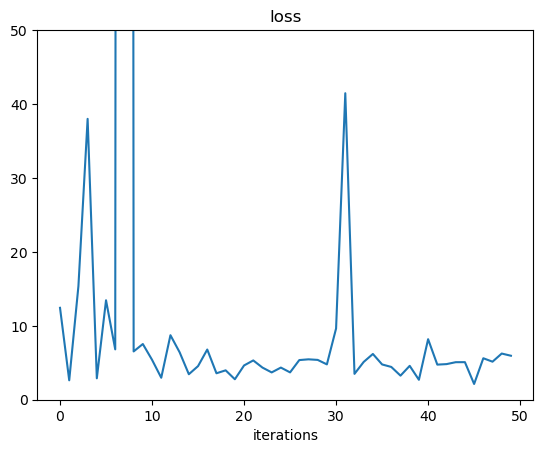

In [17]:
fig = plt.figure()
plt.plot(np.arange(len(losses)), losses)
plt.title('loss')
plt.xlabel('iterations')
plt.ylim(0,50)
plt.show()

### Test

In [85]:
ncomp = 1
xdim = 1

model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp)
model = torch.load('params/truncNNdim1-1to1.pth')

C:\Users\birik\AppData\Local\Temp\ipykernel_20568\2786245131.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('params/truncNNdim1-1to1.pth')


In [90]:
test_weights = torch.rand(ncomp)
test_weights = test_weights / test_weights.sum()  # Normalize to sum to 1
test_means = torch.empty(ncomp, xdim).uniform_(0, 10)
test_covariances = torch.empty(ncomp, xdim, xdim).uniform_(EPS, 5)

test_params = torch.hstack((test_weights, test_means.flatten(), test_covariances.flatten()))

pi_pred, mu_pred, sigma_pred = model(test_params)

print('Test params:', test_weights, test_means, test_covariances)
print('Pred params:', pi_pred, mu_pred, sigma_pred)

Test params: tensor([1.]) tensor([[6.1747]]) tensor([[[0.8025]]])
Pred params: tensor([1.], grad_fn=<DivBackward0>) tensor([[18.9858]], grad_fn=<ViewBackward0>) tensor([[2.0688e-05]], grad_fn=<ViewBackward0>)


In [91]:
import libSOGA

soga_dist = libSOGA.Dist(['x'], libSOGA.GaussianMix(np.array([1.]), [np.array(test_means[0])], [np.array(test_covariances[0])]))
_, new_soga_dist = libSOGA.truncate(soga_dist, 'x>0', {})

soga_w = new_soga_dist.gm.pi[0]
soga_mean = new_soga_dist.gm.mu[0]
soga_cov = new_soga_dist.gm.sigma[0]

soga_w, soga_mean, soga_cov

(1.0, array([6.17472601]), array([[0.8024537]]))

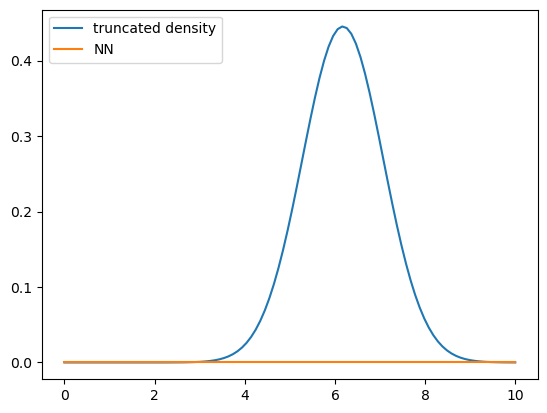

In [92]:
from scipy.stats import truncnorm
from scipy.stats import norm

# Plotting
x = GRID.numpy()

loc = test_means[0]
scale = np.sqrt(test_covariances[0])
a = -loc/scale
b = np.inf

y_trunc = truncnorm.pdf(x, a, b, loc, scale).reshape(x.shape)
y_soga = norm.pdf(x, soga_mean, np.sqrt(soga_cov)).reshape(x.shape)
y_nn = norm.pdf(x, mu_pred.detach().numpy(), np.sqrt(sigma_pred.detach().numpy())).reshape(x.shape)

plt.plot(x, y_trunc, label='truncated density')
#plt.plot(x, y_soga, label='SOGA')
plt.plot(x, y_nn, label='NN')

plt.legend()